# Introduction

* This notebook contains the code for solving the notMNIST dataset by combining methods from Deep Learning and Topological Data Analysis.
* These are independent and unique methods for solving the classification task and have given ~88.9% and ~84.4% accuracy on the test-set. 
* The independence of these techniques can be shown by their prediction results in the form of their respective confusion matrices and we shall see how we can leverage them by using an Ensemble of these two techniques. 

## Pipeline
1. Deep Learning:
    * The idea is to train a Variational Autoencoder to compress the images from the notMNIST dataset. 
    * The pytorch model used for the exercise will be explained in the report. 
    * After the VAE is trained, a latent vector is sampled from the encoder which will consumed by a Logisitic Regression model to classify them into the correct classes. 
    <br>
2. Topological Data Analysis:
    * The key idea of this component of the project is to generate topologically relevant features from the image data which can aid in training the linear model. 
    * The relevance and the type of information captured by these features will be explained in the report. 
    * A similar Logistic Regression model is trained once these features are computed. 
    * Analysis of the confusion matrix will provide evidence for the type of classification that was made. 
    
3. Ensemble Learning:
    * We try to combine the features from both the methods and is then modeled using a GBDT Classifier for the classification task. Test-set accuracy ~94%

# Code
## Necessary Imports for the execution

### Pytorch imports

In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as t
from torch.utils.tensorboard import SummaryWriter
from VAE import VAE # A seperate python file describes the architecture of the VAE

device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
try:
    print(T.cuda.get_device_name(device))
except Exception as e:
    print('CUDA device not found, using CPU instead.')

NVIDIA GeForce MX150


### Giotta-tda imports

In [11]:
from gtda.plotting import plot_heatmap
from gtda.images import Binarizer
from gtda.images import RadialFiltration
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler
from gtda.diagrams import HeatKernel
from gtda.diagrams import Amplitude
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

### Sklearn imports

In [67]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline, make_union
from sklearn import set_config
set_config(display='diagram')

### Utility imports

In [33]:
import os
from tqdm import tqdm
from glob import glob
import numpy as np
from collections import OrderedDict
from PIL import Image as PIL_Image
import cv2
from ipywidgets import interact, interact_manual
from IPython.display import clear_output, display
from IPython.display import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

 # Utility function
from pytorch_utils import get_dataloaders, get_video, get_clf_stats, save_data, load_data

### Train-test split

* For this project I've chosen to take a 75%-25% train-test stratified split. 
* There are about 14038 images in the training-set and 4686 images in the testing set.
* We generate data-loaders for each of these sets, these will be consumed by the VAE

In [3]:
np.random.seed(1234)
dataset_path = os.getcwd() + '/notMNIST/notMNIST_small'
train_dict = {}
test_dict = {}
split = 0.75
for folder in os.listdir(dataset_path):
    class_data = dataset_path + '/' + folder
    img_paths =[class_data + '/' + i for i in os.listdir(class_data)]
    np.random.shuffle(img_paths)
    train_dict[folder] = img_paths[:int(split * len(img_paths))]
    test_dict[folder] = img_paths[int(split * len(img_paths)):]

# get_dataloaders is one of pytorch_utils function
train_dataloader = get_dataloaders(train_dict, name='train-set')
test_dataloader = get_dataloaders(test_dict, name='test-set')

100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Missed examples ->  {'A': 1, 'F': 1}
train-set size: 14038


100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]

Missed examples ->  {}
test-set size: 4686


## Variational Autoencoder

### Training Procedure
* VAE trains with a loss function called ELBO Loss and has two components in it- The Reconstruction Loss and the KL Divergence Loss
* A Reduce LR on plateau learning-rate scheduler is introduced to get avoid training mishaps
* All the loss are logged into the tensorboard event files for visualization

In [4]:
%%time

VAE_network = VAE().to(device)
writer = SummaryWriter('logs/vae')
model_path = os.getcwd() + '/tmp/vae/'
model_name = 'notMNIST_vae_dec_10'
vae_model_path = model_path + model_name + '.pth'
lr = 1e-4
epochs = 200
lambda_reg = 2
optimizer = optim.Adam(VAE_network.parameters(), weight_decay=lambda_reg, lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

if os.path.exists(vae_model_path):
    print('VAE already exists. Loading model.')
    VAE_network.load_state_dict(T.load(vae_model_path, map_location=device))
    VAE_network.eval()
    
else:
    print('Training VAE')
    mean_train_loss = []
    mean_test_loss = []
    curr_loss = 0
    prev_loss = np.inf
    for epoch in range(epochs):
        train_loss = []
        test_loss = []
        for i, train_data in enumerate(train_dataloader):
            x_train, y_train = train_data
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            y_train_pred, mean, logvar = VAE_network.forward(x_train)
            batch_size = x_train.shape[0]
            reconstruction_loss = F.mse_loss(y_train_pred, y_train, reduction='sum') / batch_size
            KLD_loss = -0.5 * T.sum(1 + logvar - mean.pow(2) - logvar.exp()) / batch_size
            loss = reconstruction_loss + 3 * KLD_loss
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            writer.add_scalar('Train loss', loss.item(), epoch * len(train_dataloader) + i)

        train_mean_loss = np.mean([i.item() for i in train_loss])
        mean_train_loss.append(train_mean_loss)
        with T.no_grad():
            for i, test_data in enumerate(test_dataloader):
                x_test, y_test = test_data
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                y_pred, mean, logvar = VAE_network.forward(x_test)
                loss = F.mse_loss(y_pred, y_test, reduction='sum') / batch_size
                test_loss.append(loss)
                writer.add_scalar('Test loss', loss.item(), epoch * len(test_dataloader) + i)

            test_mean_loss = np.mean([i.item() for i in test_loss])
            mean_test_loss.append(test_mean_loss)
            print('Epoch, Train-loss, Valid-loss: {}, {}, {}'.format(epoch + 1, train_mean_loss, test_mean_loss))
            scheduler.step(test_mean_loss)
            curr_loss = test_mean_loss
            if curr_loss < prev_loss and epoch > 50 and epoch % 10 == 0:
                print('Saving Model at epoch {}'.format(epoch+1))
                T.save(VAE_network.state_dict(), model_path + model_name + '.pth')
                prev_loss = curr_loss

    x_loss = mean_train_loss
    y_loss = mean_test_loss
    plt.plot(range(len(x_loss)), x_loss, label='Training-Loss')
    plt.plot(range(len(y_loss)), y_loss, label='Validation-Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

VAE already exists. Loading model.
CPU times: user 6.95 s, sys: 2.57 s, total: 9.52 s
Wall time: 42.6 s


### VAE Reconstruction

The reconstructed output and the initial input are generated into a video format using one of the utility function for visualization

In [5]:
test_list = []
pred_list = []

for i, test_data in enumerate(test_dataloader):
    x_test, y_test = test_data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred, mean, logvar = VAE_network.forward(x_test)
    test_point = x_test.detach().cpu().numpy()
    pred_point = y_pred.detach().cpu().numpy()
    test_list.append(test_point[0])
    pred_list.append(pred_point[0])
    
test_arr = np.array(test_list)
pred_arr = np.array(pred_list)

# get_video is a pytorch_utils function to visualize the real image and the reconstructed image 
name = 'vae_video_10Dec'
get_video(test_arr, pred_arr, name)

OpenCV: FFMPEG: tag 0x4745504d/'MPEG' is not supported with codec id 2 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Converting predictions to video


100%|██████████████████████████████████████████| 74/74 [00:00<00:00, 294.48it/s]


### Latent-vector dataset 

* Using the encoder from the VAE, I sampled z latent vectors by running a forward pass of the encoder
* These vectors are a 32-dimensional representation of the original image set

In [6]:
# get_dataloaders method is a method from pytorch_utils 
z_train_dataloader = get_dataloaders(train_dict, batch_size=1, name='train-set', return_label=True)
z_test_dataloader = get_dataloaders(test_dict, batch_size=1, name='test-set', return_label=True)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.16it/s]


Missed examples ->  {'A': 1, 'F': 1}
train-set size: 14038


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.72it/s]

Missed examples ->  {}
test-set size: 4686


In [7]:
def get_latent_data(dataloader):
    images, features, labels = [], [], []
    for data in tqdm(dataloader):
        with T.no_grad():
            x, y = data
            x = x.to(device)
            y = y.numpy()
            z = VAE_network.forward(x, encoder=True, decoder=False)
            z = z.detach().cpu().numpy()
            images.append(x.detach().cpu().numpy()[0])
            features.append(z[0])
            labels.append(int(y[0]))    
    return np.array(images), np.array(features), np.array(labels)
            
images_train, x_train, y_train = get_latent_data(z_train_dataloader)
images_test, x_test, y_test = get_latent_data(z_test_dataloader)

100%|██████████████████████████████████████| 4686/4686 [00:09<00:00, 512.17it/s]


### Logistic Regression model

1. A LR model is trained on the latent vector dataset 
2. The LR model is then evaluated on the test set to assess its performance

In [130]:
grid = {"C":np.logspace(-3,3,7), 
        "penalty":['l1', 'l2']}

vae_lr = LogisticRegression(solver='saga', multi_class='multinomial')
vae_lr_estimator = GridSearchCV(vae_lr, grid, cv=5, n_jobs=-1, verbose=0)
vae_lr_estimator.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

Classifier Accuracy:  0.8892445582586428
Classification Report: 
               precision    recall  f1-score   support

           A       0.90      0.90      0.90       469
           B       0.89      0.89      0.89       469
           C       0.91      0.91      0.91       469
           D       0.91      0.93      0.92       469
           E       0.87      0.84      0.86       469
           F       0.91      0.92      0.91       469
           G       0.87      0.87      0.87       468
           H       0.89      0.88      0.88       468
           I       0.85      0.86      0.85       468
           J       0.89      0.90      0.89       468

    accuracy                           0.89      4686
   macro avg       0.89      0.89      0.89      4686
weighted avg       0.89      0.89      0.89      4686



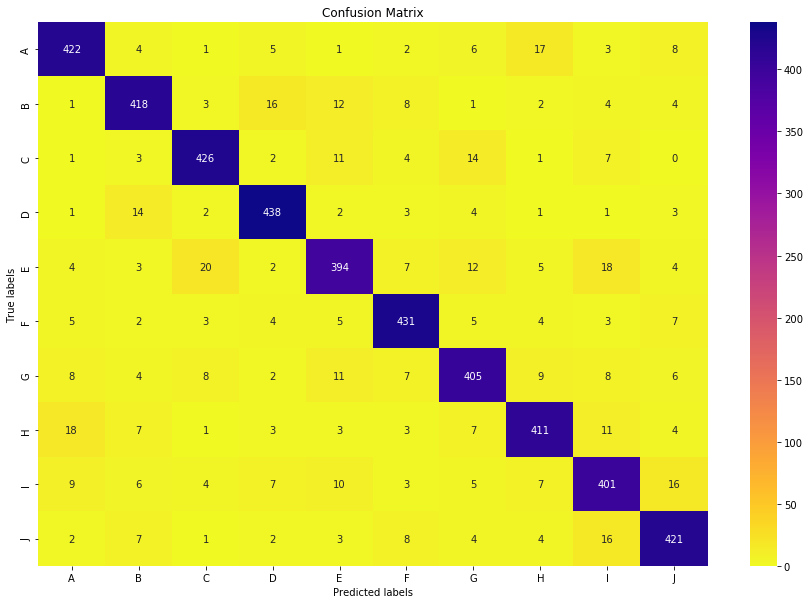

In [188]:
vae_cf = get_clf_stats(vae_lr_estimator, x_test, y_test)

## Topological Data Analysis

1. Let's first visualize one of the training images that's causing problems
2. Some of the letters that caused issues are: B&D, B&E, A&H etc.
3. Let's consider the letter B. The topological differentiators of this letter are:
    * Letter B is the only one amongst the labels that have two loops in them
    * If we were to remove one of the loops it becomes the letter D
    * If we were to remove both the loops then it becomes the letter E
    
### Image Representation 

Let's see how we can extract topological information for the letter B from it's image representation

In [160]:
img = images_train[1].reshape(28, 28)
plot_heatmap(img)

### Binary Representation

The image can be binarized (pixel values belong to {0,1}) by setting a threshold value

In [161]:
binarizer = Binarizer(threshold=0.2)
img_binarized = binarizer.fit_transform(img.reshape(1, 28, 28))
binarizer.plot(img_binarized)

### Filtration

In mathematics, a filtration F is an indexed family of subobjects of a given algebraic structure S, with the index i running over some totally ordered index set I, subject to the condition that if i ≤ j in I, then S[i] ⊆ S[j] 

The radial filtration assigns to each pixel of a binary image a greyscale value computed as follows in terms of a reference pixel, called the “center”, and of a “radius”: if the binary pixel is active and lies within a ball defined by this center and this radius, then the assigned value equals this distance. In all other cases, the assigned value equals the maximum distance between any pixel of the image and the center pixel, plus one.

TLDR; The binarized pixels are assigned a value that's dependent on it's distance from the upper right corner of the image. Pixels closer to the upper right corner have lower values and keeps increasing once they move farther away 

In [162]:
radial_filtration = RadialFiltration(center=np.array([20, 6]))
img_filtration = radial_filtration.fit_transform(img_binarized)
radial_filtration.plot(img_filtration, colorscale="jet")

### Persistent Homology

Persistent homology is a method for computing topological features of a space at different spatial resolutions. More persistent features are detected over a wide range of spatial scales and are deemed more likely to represent true features of the underlying space rather than artifacts of sampling, noise, or particular choice of parameters.

In our use case Persistent Homology can be used to calculate the edges and loops that are present in the figure. H0 persistence (red dots) in the figure below represent the number of edges in the image and the H1 persistence (green dots) in the figure below represents the existense of loops in the image.

In [163]:
cubical_persistence = CubicalPersistence(n_jobs=-1)
img_cubical = cubical_persistence.fit_transform(img_filtration)
cubical_persistence.plot(img_cubical)

### Scaling the Persistence diagram

Scales of Persistence diagrams for different inputs change as it's dependent on the time a certain structure in the input persists. It's necessary to scale these value to get unbiased feature values.

In [21]:
scaler = Scaler()
img_scaled = scaler.fit_transform(img_cubical)
scaler.plot(img_scaled)

### Feature Representation

* Persistent Homology needs to be translated to a meaningful metric for it to be considered as a feature
* This can be achieved by convolving a gaussian kernal on the persistence diagram, a procedure achieved via the heat kernel
* For each of the Homology dimension, the Heat Kernels amplitude is computed to get the vectorized feature

In [22]:
heat = HeatKernel(sigma=.15, n_bins=100, n_jobs=-1)
img_heat = heat.fit_transform(img_scaled)

fig1 = heat.plot(img_heat, homology_dimension_idx=0, colorscale='jet')
fig1.show()

fig2 = heat.plot(img_heat, homology_dimension_idx=1, colorscale='jet')
fig2.show()

### Sklearn pipeline 

Giotta-tda allows us to create a sklearn-like pipeline function to create different recipes for feature engineering tasks. In this exercise we create a HeatKernel based Persistence Feature.

In [23]:
steps = [
    ("binarizer", Binarizer(threshold=0.2)),
    ("filtration", RadialFiltration(center=np.array([20, 6]))),
    ("diagram", CubicalPersistence()),
    ("rescaling", Scaler()),
    ("amplitude", Amplitude(metric="heat", metric_params={'sigma':0.15, 'n_bins':60}))
]

heat_pipeline = Pipeline(steps)
img_feature = heat_pipeline.fit_transform(img.reshape(1, 28, 28))
print('Heat Kernel feature value for the input image: {}'.format(img_feature))

Heat Kernel feature value for the input image: [[0.         2.49781365]]


### TDA feature generation pipeline

* Heat Kernel is just one type of feature generation technique
* A bunch of them can be found within the giotta-tda API and the idea is to compute some of them
* In this exercise, the following types have been computed:
    * Amplitudes using the following metrics:
        * Bottleneck distances
        * Wasserstein distances
        * Persistence Landscapes
        * Betti vectors
        * Heat-Kernels
    * Persistence Entropy

In [24]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], 
                  [-1, 0], [-1, -1], [0, -1], [1, -1]]
height_filtrations = [HeightFiltration(direction=np.array(direction), 
                                       n_jobs=-1) for direction in direction_list]

center_list = [[13, 6], [6, 13], [13, 13], [20, 13], [13, 20], 
               [6, 6], [6, 20], [20, 6], [20, 20]]
radial_filtrations = [RadialFiltration(center=np.array(center), 
                                       n_jobs=-1) for center in center_list]

filtration_list = (height_filtrations + radial_filtrations)
diagram_steps = [[Binarizer(threshold=0.4, n_jobs=-1), 
                  filtration, 
                  CubicalPersistence(n_jobs=-1), 
                  Scaler(n_jobs=-1)] for filtration in filtration_list]

metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

feature_union = make_union(*[PersistenceEntropy(nan_fill_value=-1)] + 
                           [Amplitude(**metric, n_jobs=-1) for metric in metric_list])

tda_union = make_union(*[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps], 
                       n_jobs=-1)

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-11',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-12',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-13',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1))]))]))])

In [25]:
x_images_train = images_train.reshape((-1, 28, 28))
x_images_test = images_test.reshape((-1, 28, 28))
print('Train Image, Latent Vector, Label: ', x_images_train.shape, x_train.shape, y_train.shape)
print('Test Image, Latent Vector, Label: ', x_images_test.shape, x_test.shape, y_test.shape)

Train Image, Latent Vector, Label:  (14038, 28, 28) (14038, 32) (14038,)
Test Image, Latent Vector, Label:  (4686, 28, 28) (4686, 32) (4686,)


In [26]:
%%time 

x_train_tda = tda_union.fit_transform(x_images_train)
x_train_tda.shape

CPU times: user 2.49 s, sys: 1.94 s, total: 4.43 s
Wall time: 1h 46min 29s


(14038, 476)

In [27]:
%%time

x_test_tda = tda_union.transform(x_images_test)
x_train_tda.shape, x_test_tda.shape

CPU times: user 701 ms, sys: 1.04 s, total: 1.74 s
Wall time: 27min 30s


((14038, 476), (4686, 476))

In [37]:
tda_train_data = np.concatenate((x_train_tda, y_train.reshape(-1, 1)), axis=1)
tda_test_data = np.concatenate((x_test_tda, y_test.reshape(-1, 1)), axis=1)
save_data(tda_train_data, tda_test_data, 'tda_Dec17')
tda_train_data.shape, tda_test_data.shape

((14038, 477), (4686, 477))

In [38]:
x_train_ = np.concatenate((x_train, x_train_tda), axis=1)
x_test_ = np.concatenate((x_test, x_test_tda), axis=1)
x_train_.shape, x_test_.shape

((14038, 508), (4686, 508))

### Logistic Regression model

In [132]:
grid = {"C":np.logspace(-3,3,7), 
        "penalty":['l1', 'l2']}

tda_lr = LogisticRegression(solver='saga', multi_class='multinomial')
tda_lr_estimator = GridSearchCV(tda_lr, grid, cv=5, n_jobs=-1, verbose=0)
tda_lr_estimator.fit(x_train_tda, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

Classifier Accuracy:  0.8440034144259496
Classification Report: 
               precision    recall  f1-score   support

           A       0.81      0.85      0.83       469
           B       0.81      0.85      0.83       469
           C       0.87      0.84      0.86       469
           D       0.85      0.84      0.85       469
           E       0.87      0.88      0.87       469
           F       0.91      0.84      0.87       469
           G       0.81      0.82      0.82       468
           H       0.88      0.88      0.88       468
           I       0.79      0.85      0.82       468
           J       0.84      0.77      0.81       468

    accuracy                           0.84      4686
   macro avg       0.85      0.84      0.84      4686
weighted avg       0.85      0.84      0.84      4686



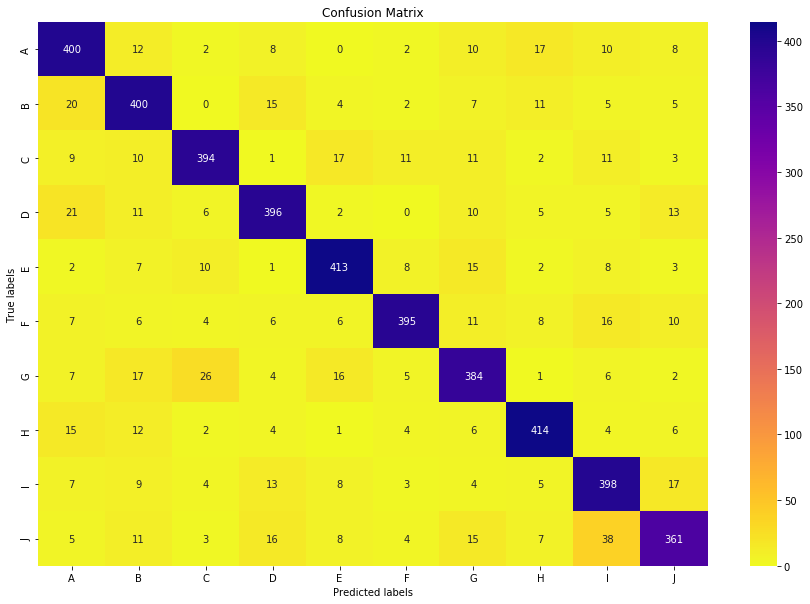

In [189]:
tda_cf = get_clf_stats(tda_lr_estimator, x_test_tda, y_test)

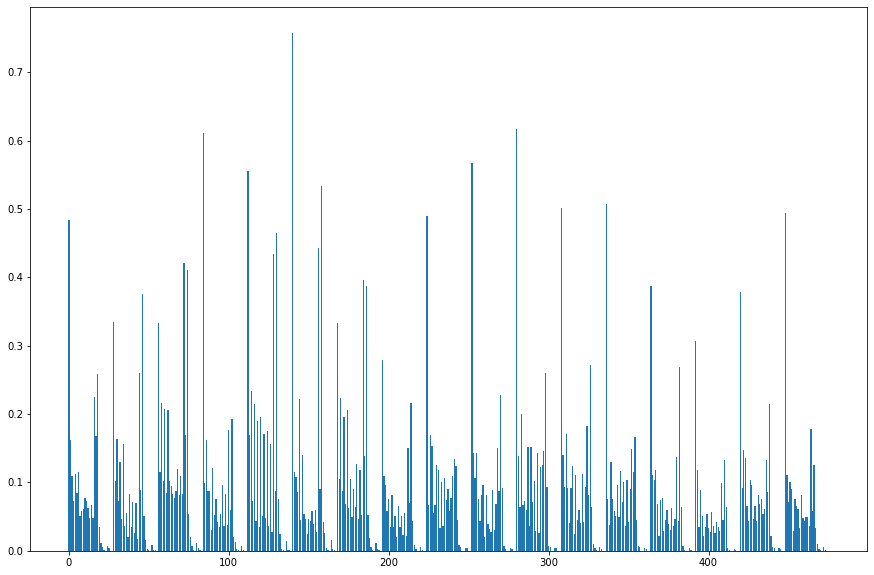

In [198]:
weights = tda_lr_estimator.best_estimator_.coef_
plt.bar(list(range(weights.shape[1])), np.max(np.abs(weights), axis=0))
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

## Deep Learning and TDA based Ensemble Models

### GBDT classifier Model
* Idea is to combine Deep Learning and TDA features 
* In this exercise I combined them by just concatenating the two data arrays
* These resultant data-array is then used to fit a GBDT classifier

In [192]:
from sklearn.preprocessing import RobustScaler

r_scaler = RobustScaler()
scaled_x_train = r_scaler.fit_transform(x_train_)
scaled_x_test = r_scaler.transform(x_test_)

In [194]:
vae_tda_lgb_estimator = lgb.LGBMClassifier(boosting='gbdt',
                                       objective='multiclass', 
                                       num_iterations=500, 
                                       learning_rate=0.2, 
                                       metric='auc_mu',
                                       max_depth=30,
                                       n_estimators=1000, random_state=1234)
 
vae_tda_lgb_estimator.fit(scaled_x_train, y_train)

LGBMClassifier(boosting='gbdt', learning_rate=0.2, max_depth=30,
               metric='auc_mu', n_estimators=1000, num_iterations=500,
               objective='multiclass', random_state=1234)

Classifier Accuracy:  0.9406743491250533
Classification Report: 
               precision    recall  f1-score   support

           A       0.94      0.95      0.94       469
           B       0.90      0.96      0.93       469
           C       0.94      0.93      0.94       469
           D       0.95      0.97      0.96       469
           E       0.94      0.93      0.93       469
           F       0.97      0.95      0.96       469
           G       0.95      0.93      0.94       468
           H       0.96      0.93      0.94       468
           I       0.92      0.91      0.92       468
           J       0.95      0.94      0.95       468

    accuracy                           0.94      4686
   macro avg       0.94      0.94      0.94      4686
weighted avg       0.94      0.94      0.94      4686



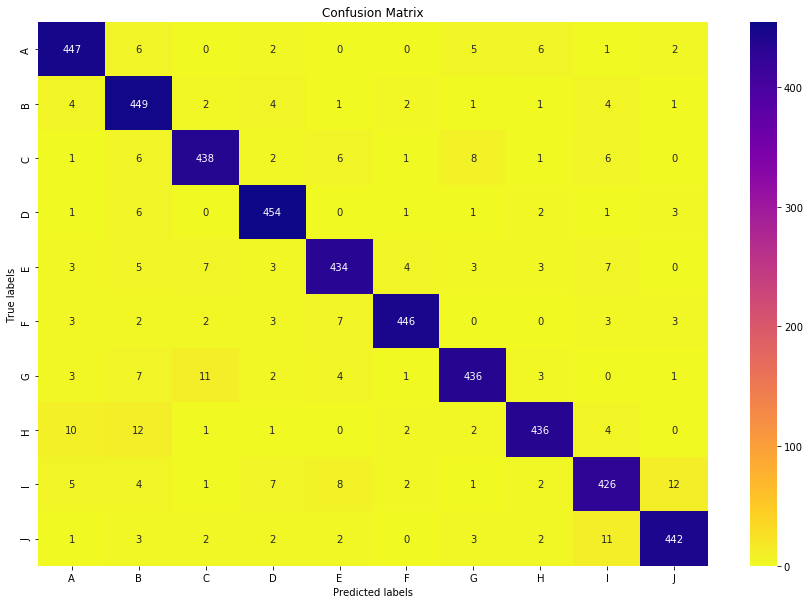

In [195]:
vae_tda_cf = get_clf_stats(vae_tda_lgb_estimator, scaled_x_test, y_test)

### Confusion Matrix Analysis 

We can visualize how much the performance has improved for every class by checking the trace of difference of confusion matrices between various methods

In [196]:
a = vae_cf
b = tda_cf
c = vae_tda_cf

#### VAE+TDA model and VAE model 

As the diagram suggests, the combined model got a boost over the VAE model in predicting the following classes:
* B by 9.18%
* G by 5.61%
* E by 3.57%

Improvement-score after combining:  5.7835373170146385


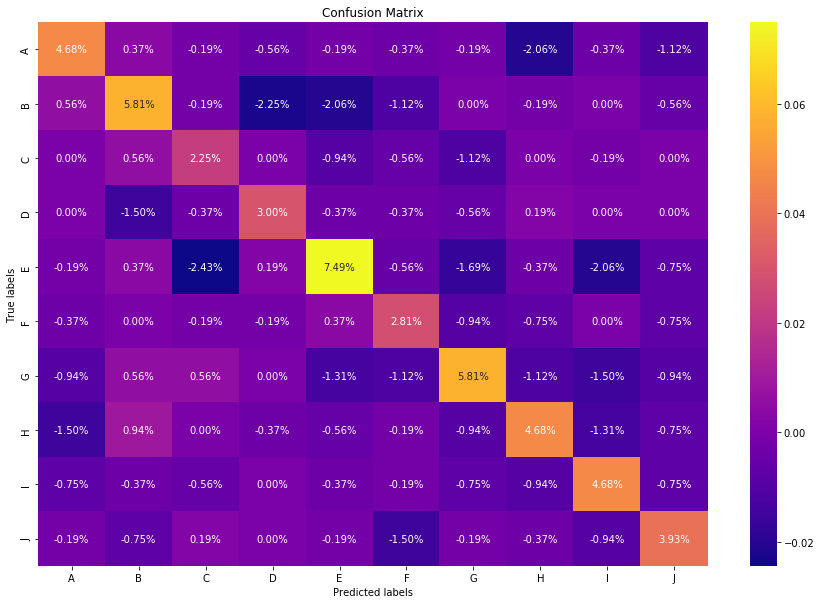

In [197]:
ax= plt.subplot()
vt_minus_v = c - a
print('Improvement-score after combining: ', np.trace(vt_minus_v) * 100/np.trace(a))
sns.heatmap(vt_minus_v/np.sum(np.absolute(vt_minus_v)), annot=True, fmt='.2%', cmap='plasma')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()